In [1]:
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

import torch
import torch.nn as nn
import torch 
from torch_geometric.nn import NNConv
import torch.nn.functional as F
# from test_model import Encoder

: 

In [ ]:
data = QM9(root='./practice_data', transform=None)

"""
each batch is considered a hugh graph with many nodes and edges,
in EGNN, they introduce the concept of l2 distance between nodes, 
yet I am not including this (probably not) for now. 


"""
dataloader = DataLoader(data, batch_size=1, shuffle=True) 
for i , x in enumerate(dataloader):
    print(x)
    cat = torch.concat((x.x[:,:4], x.pos), axis=1)
    print(cat.shape)
    if i > 20: 
        break

In [3]:
dummy = next(iter(dataloader))
print(dummy)
edg = dummy.edge_index
print(dummy.edge_index)

DataBatch(x=[578, 11], edge_index=[2, 1186], edge_attr=[1186, 4], y=[32, 19], pos=[578, 3], idx=[32], name=[32], z=[578], batch=[578], ptr=[33])
tensor([[  0,   0,   1,  ..., 575, 576, 577],
        [  1,   9,   0,  ..., 563, 564, 564]])


# PYG 

- [qm9 example](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/qm9_nn_conv.py)


## Node Embedding 

#### Why Use Node Embeddings ?
Node embeddings have a number of advantages over other methods for learning node representations. First, node embeddings can be trained using standard neural network optimization methods. Second, node embeddings can be trained on graphs with arbitrary structure. Finally, node embeddings can be used to represent nodes in multiple graphs simultaneously.


#### How are Node Embeddings Learned ?
Node embeddings are learned by training a neural network to map nodes in a graph to low-dimensional vectors. The network is trained using a loss function that encourages the vectors for similar nodes to be close together and the vectors for dissimilar nodes to be far apart.


#### The process of Node embedding 
The neural network takes the graph as input and applies a series of operations to transform the node features and capture the relationships between nodes. These operations can include ***graph convolutional layers, pooling layers, or attention mechanisms***, depending on the specific architecture of the neural network.





Resource:
- [node embedding tutorial](https://medium.com/the-modern-scientist/graph-neural-networks-series-part-3-node-embedding-36613cc967d5)



# Encoder

### GCN (Graph Convolutional Layer)

GCN consist of the convolution operations to edges and nodes features, the technique is mainly used to embed the molecules (graph representation) to an embedded space. There consists of two models, ***1) node mlp*** and ***2) edge mlp***. 

*** *Following is my own understanding* ***


Inside the GCL, the initial $h_0$ is atoms features, including the atom types and charges (concated tensor). Are edge features the adjacency matrix?? In addition to the edge features, edge attributes (how do i put adj matrix inside my code). 



# PyG NNConvolution 

Edge conditioned convolution 

input: nodes features (embedding): $(|V|, N_{feat})$
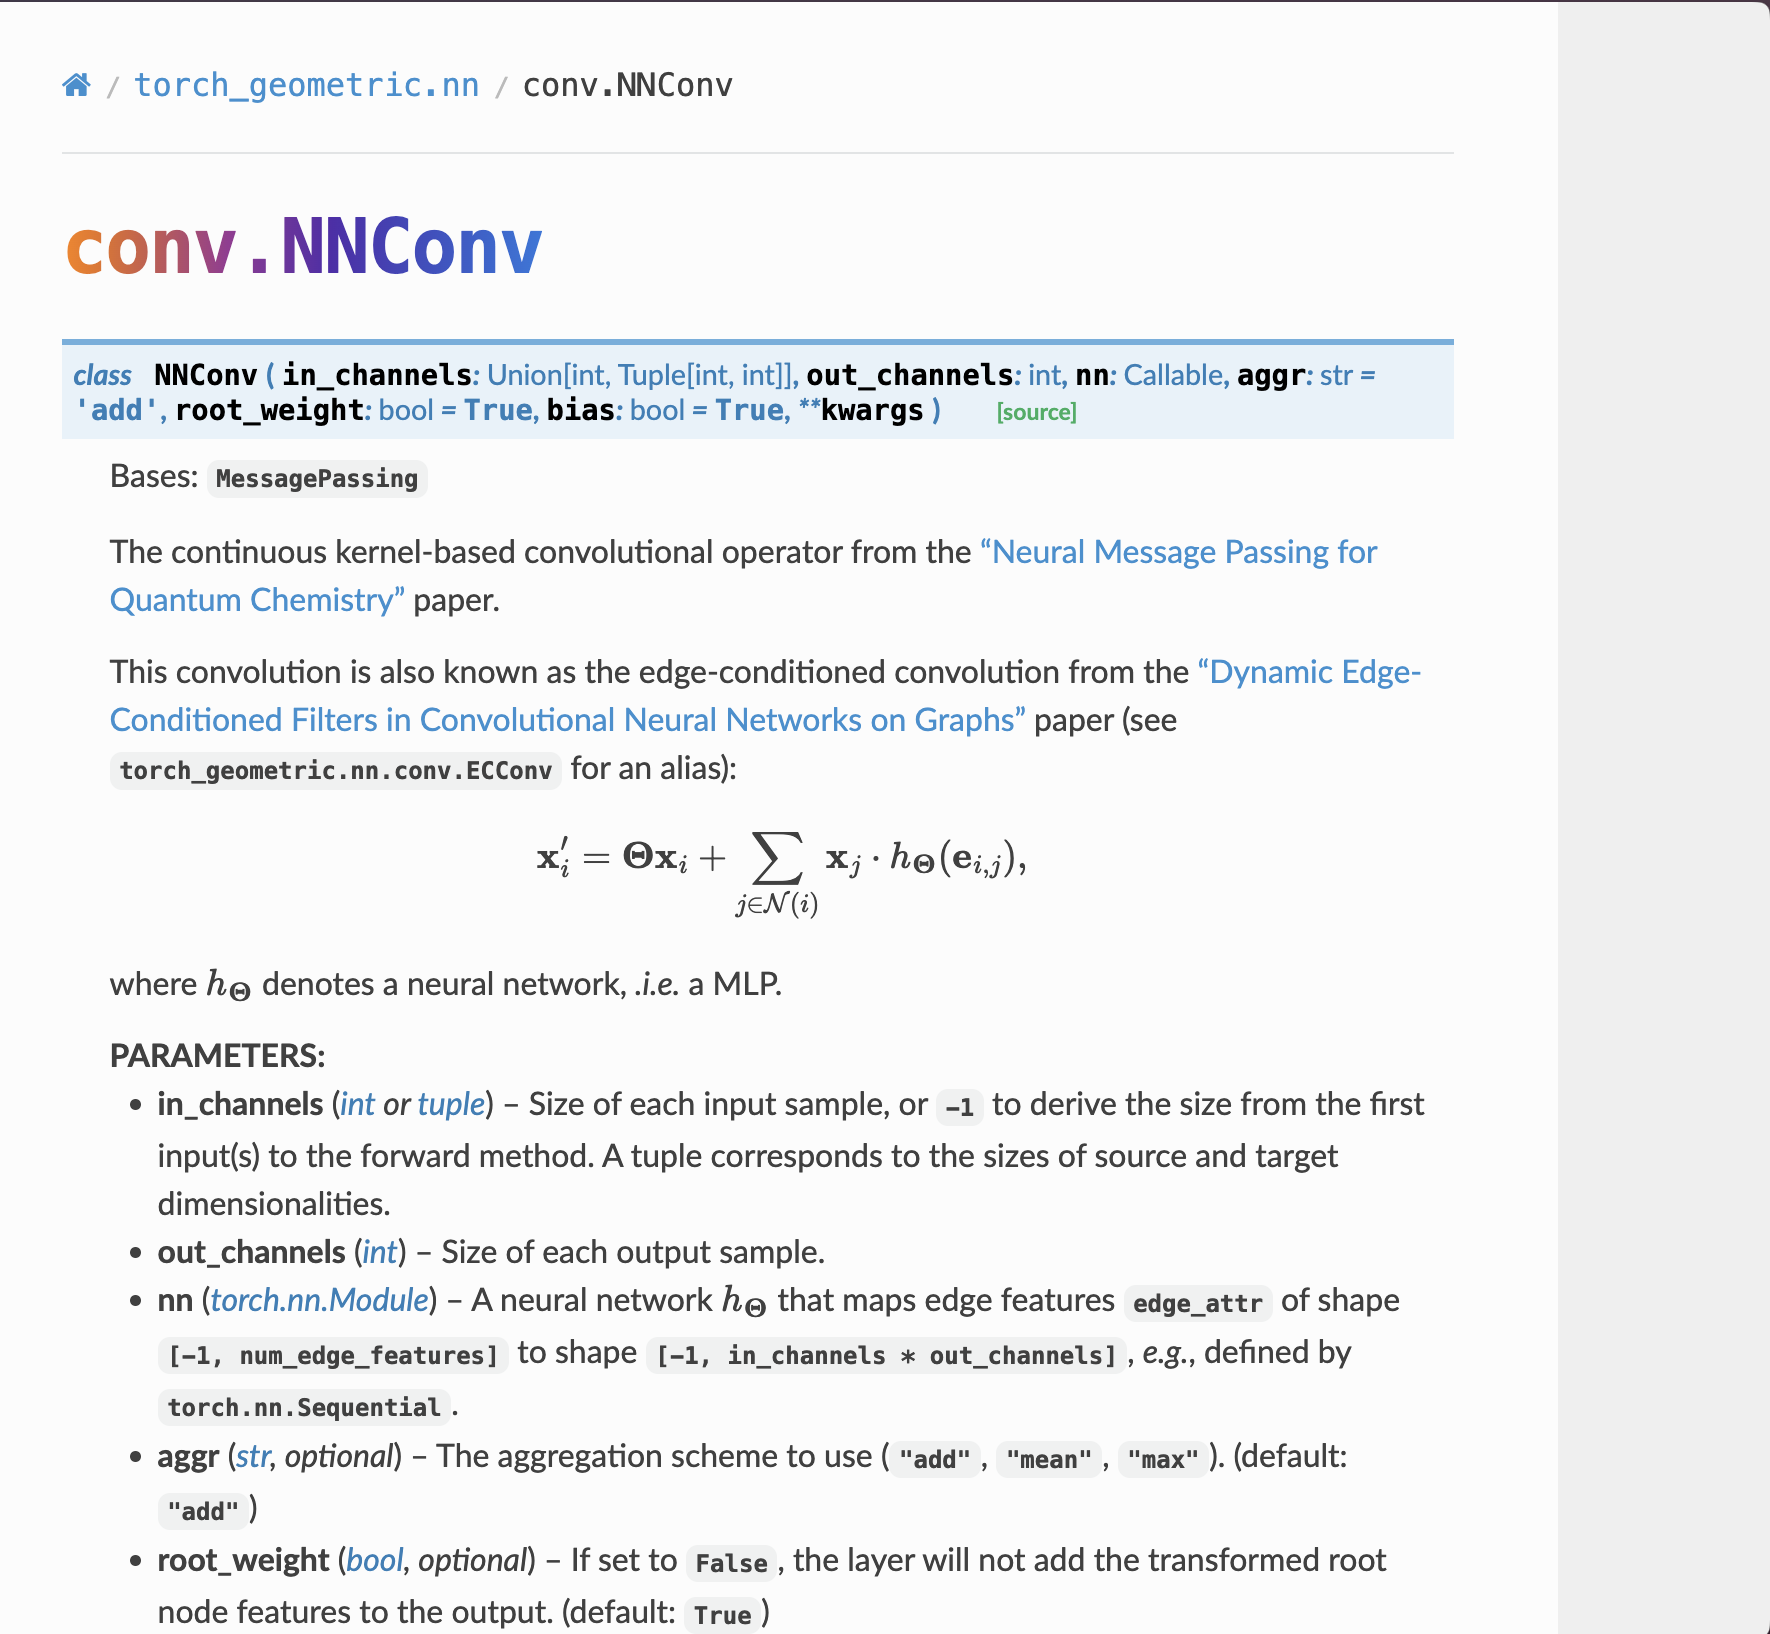

In [6]:
import torch
import torch.nn as nn
import math
from torch_geometric.nn import NNConv, GATConv, GCNConv
from DiffuseSampler import DiffuseSampler

# Graph Convolution Layer
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, edge_attr_dim=0, aggr="mean",activation=nn.SiLU(), attention=False):
        super(GraphConv, self).__init__()
        self.activation = activation
        
        
        if edge_attr_dim > 0:
            nn_model = nn.Sequential(
                    nn.Linear(edge_attr_dim, 32), 
                    self.activation,
                    nn.Linear(32, in_channels*in_channels)
            )
            self.gc_edge_attr = NNConv(in_channels, in_channels, nn_model, aggr)
            self.linear = nn.Linear(in_channels, out_channels)
        
        
        self.time_mlp = nn.Linear(time_emb_dim, out_channels) # (n_sample, out_channels)
        

        
        if attention: 
            self.gc = GATConv(in_channels, out_channels)
        else:
            self.gc = GCNConv(in_channels, out_channels)
        
        self.lin = nn.Linear(out_channels, out_channels)
            
        
    
    # if edge_attr is None, will not convolve the edge attributes 
    def forward(self, x, edge_index,t, edge_attr=None):
        if edge_attr is None:
            x = self.activation(self.gc(x,edge_index))
        else:
            x = self.activation(self.gc_edge_attr(x, edge_index, edge_attr))
            x = self.activation(self.linear(x))
            
            
        time_emb = self.activation(self.time_mlp(t))
        # print("shape x: ", x.shape)
        # print("shape time_emb: ", time_emb.shape)
        x += time_emb
        x = self.activation(self.lin(x))
        
        return x

# for time embedding (Sinusoidal time embedding)
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

# edge attributes NN
class NNEdgeAttr(nn.Module):
    def __init__(self, edge_in_dim, edge_out_dim, act):
        super(NNEdgeAttr, self).__init__()
        # if edge_attr:
        self.act = act 
        self.self.edge_attr_nn = nn.Sequential(
                nn.Linear(edge_in_dim, edge_out_dim), 
                self.act,
                nn.Linear(edge_out_dim, edge_out_dim*edge_out_dim)
                ) # NN convolution block for edge conditioned convolution
    def forward(self,x):
        out = self.edge_attr_nn(x)
        return out
        


# Encoder 
class Net(nn.Module):
    # def __init__(self, n_feat_in, hidden_dim, latent_dim, time_emb_dim,n_layers, activation= nn.SiLU(), edge_attr_dim = None):
    def __init__(self, n_feat_in, layers, time_emb_dim, activation= nn.SiLU(), edge_attr_dim = 0):
        super(Net, self).__init__()
        # self.device = device
        # self.n_layers = n_layers
        self.layers = layers
        self.act = activation
        self.embedding = nn.Linear(n_feat_in, self.layers[0]) # initialize the embedding layer
        self.embedding_out = nn.Linear(self.layers[0], n_feat_in) # output embedding layer (latent space)
        self.edge_attr_dim = edge_attr_dim
        # hidden_ = (64, 128, 256)
        
        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU() # maybe modify?
            )
        
    
        
        ### Encoder (Downsampling)
        # graph convolution layers
        
        self.downsampling = nn.ModuleList([
            GraphConv(in_channels=self.layers[i], out_channels=self.layers[i+1], time_emb_dim=time_emb_dim, edge_attr_dim = self.edge_attr_dim, aggr='add', activation=self.act)
            for i in range(0,len(self.layers)-1)
        ]
        )
        
        ### Decoder (Upsampling)
        self.upsampling = nn.ModuleList([
            GraphConv(in_channels=self.layers[i], out_channels=self.layers[i-1],time_emb_dim=time_emb_dim, edge_attr_dim=self.edge_attr_dim, aggr='add', activation=self.act)
            for i in reversed(range(1, len(self.layers)))
        ])
        
            
        # Pooling layers
        """
        Basically the parameters
        
        graph convolution:
        - forward pass: (x:nodes embedding, edge_index: edge index, edge_attr: edge attributes)
        
        """


    def forward(self, x, timestep,edge_index, edge_attr=None):
        """_summary_

        Args:
            x (_type_): node features
            edge_index (_type_): edge index matrix, shape = [2, num_edges]
            edge_attr (_type_): edge attributes, default None


        Returns:
            h: graph latent representation
        """
        h = self.embedding(x) # initialize node embedding
        t = self.time_mlp(timestep)
        # print("initial h:", h.shape)
        
        # for i in range(self.n_layers):
        #     # print("running gcl_%d" % i)
        #     # h = self._modules["gcl_%d" % i](h, edge_index, edge_attr)
        #     # print("h in the loop:", h.shape)
        #     h = self.
        
        # downsampling 
        for down in self.downsampling:
            h = down(h, edge_index, t, edge_attr)
        
        
        # bottle neck 
        
        
        # upsampling 
        for up in self.upsampling:
            h = up(h, edge_index, t, edge_attr)
            
        
        out = self.embedding_out(h)
    
        return out
    
    
    # get loss for diffusion process
    def get_loss(self, x_0, t, edge_index,total_timestep, device, mode="linear",edge_attr=None):
        """_summary_

        Args:
            x_0 (Tensor): ground truth data
            edge_index (Tensor): edge index -> shape = (2, edge)
            total_timestep (int): Total timesteps
            t (Tensor): timesteps sample -> (n_batch, )
            device : device
            mode (String): "linear", "cosine" schedule for noise scheduling 
            edge_attr (Tensor): edge attributes -> shape = (n_edge, n_edge_feat)

        Returns:
            _type_: _description_
        """
        # generate sample 
        
        x_noised, noise = DiffuseSampler.sample_forward_diffuse_training(x_0, total_timestep, t, device,mode) # noised, noise added
        pred_noise = self.forward(x_noised, t, edge_index, edge_attr)
        metric = nn.MSELoss()
        loss = metric(pred_noise, noise)
        return loss
        
    
    # @torch.no_grad()
    # @staticmethod
    # def sample_timestep(x, t):
    #     """
    #     Calls the model to predict the noise in the image and returns
    #     the denoised image.
    #     Applies noise to this image, if we are not in the last step yet.
    #     """
    #     # Pre-calculate different terms for closed form

    #     betas_t = get_index_from_list(betas, t, x.shape)
    #     sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
    #         sqrt_one_minus_alphas_cumprod, t, x.shape
    #     )
    #     sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    #     # Call model (current image - noise prediction)
    #     model_mean = sqrt_recip_alphas_t * (
    #         x - betas_t * Net(x, t) / sqrt_one_minus_alphas_cumprod_t
    #     )
    #     posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    #     if t == 0:
    #         # As pointed out by Luis Pereira (see YouTube comment)
    #         # The t's are offset from the t's in the paper
    #         return model_mean
    #     else:
    #         noise = torch.randn_like(x)
    #         return model_mean + torch.sqrt(posterior_variance_t) * noise
        
        

# class Embedding(nn.Module):
#     def __init__(self,x_feat_shape, embedding_dim):
#         self.x_feat_shape = x_feat_shape
#         self.embed = nn.Embedding(self.x_feat_shape.shape[1], embedding_dim)
#     def forward(self,x):
#         self.embed(x)
        
# def compute_loss(model, x0, t, edge_index, )
        
    


# Sampling 
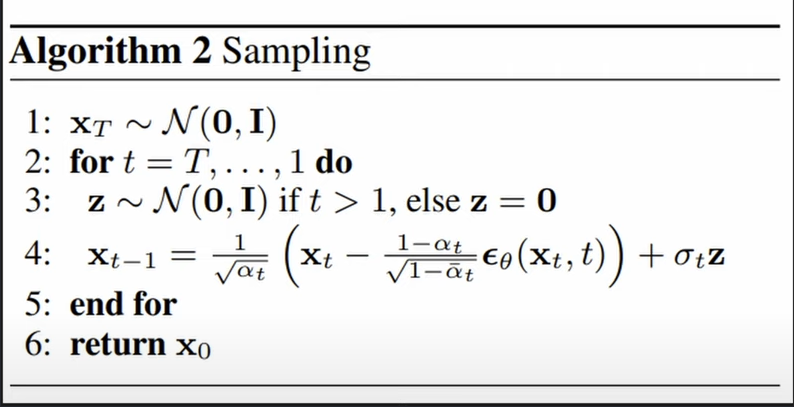

In [9]:
# Test encoder 
from tqdm import tqdm 
import torch 
from DiffuseSampler import DiffusionModel
# try the customized pyg model 
hidden_dim = 64 # hidden dimension
n_feat_out = 7 # output latent embedding shape
n_layers = 4
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_epochs = 10 
timestep = 1000 




# net = Net()
encoder = Net(
    n_feat_in=dummy.x.shape[1],
    layers=[32,64,128], 
    time_emb_dim=4).to(device)

diffusion = DiffusionModel(
    encoder, 
    timesteps=timestep,
)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
embedding = nn.Embedding(dummy.x.shape[1], 4)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    running_loss = 0
    with tqdm(dataloader) as tepoch:
        for data in tepoch:
            tepoch.set_description(f'Epoch {epoch}')
            # optimizer.zero_grad()
            data = data.to(device)
            x = torch.concat((data.x[:,:4],data.pos), axis=1) # node features -> one hot vector + positional information
            h = embedding(x)
            # what is the ts here 
            ts = torch.randint(0, timestep, (data.x.shape[0],), device=device).long()
            h_t, noise = diffusion.sample_forward_diffuse_training(h, timestep, ts, device =device, sampling_mode="cosine")
            # out = encoder(data.x, ts, data.edge_index)
            # Predict denoised data from noisy data at random timesteps
            pred_noise, x_0_pred = diffusion.model_prediction(h_t, ts)
            loss = criterion(pred_noise, noise)
            
            loss.backward()
            optimizer.step()
            running_loss += (loss.item()/len(dataloader))
            tepoch.set_postfix(train_loss=running_loss)
            

  0%|          | 0/4089 [00:00<?, ?it/s]

Epoch 2:  51%|█████     | 2066/4089 [01:21<01:20, 25.23it/s, train_loss=20.2]


KeyboardInterrupt: 

In [1]:
dummy

NameError: name 'dummy' is not defined